In [1]:
import pandas as pd
import numpy as np
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u

import cv2 as cv
from astropy import wcs

In [2]:
north_results = Table.read("north_clusters_final_2023.fits").to_pandas()

In [3]:
south_results = Table.read("south_clusters_final_2023.fits").to_pandas()

In [4]:
south_results

,RA_central,DEC_central,z_median_central,z_average_no_wt,z_average_prob,z_average_mass_prob,z_std_central,z_std_no_wt,z_std_prob,z_std_mass_prob,...,MASKBITS,gid,mass_central,neighbor_mass,local_neighbor_mass,ultra_local_neighbor_mass,correction_factor,neighbors,local_neighbors,ultra_local_neighbors
0,350.561514,28.520936,0.402490,0.420022,0.408839,0.408758,0.013443,0.085295,0.053400,0.053226,...,0,3.505615e+18,12.199634,13.377622,13.233770,12.830636,1.845499,151.033333,76.200000,7.833333
1,350.246408,29.216867,0.497572,0.504563,0.499537,0.499697,0.011251,0.082731,0.045270,0.044885,...,0,3.502464e+18,11.827673,13.434281,13.113805,12.670497,2.096312,121.733333,48.866667,7.866667
2,354.622471,27.031600,0.067650,0.162558,0.095997,0.095339,0.044711,0.106132,0.066505,0.066123,...,4096,3.546225e+18,12.354160,13.144484,12.895728,12.767303,1.370329,178.466667,41.966667,3.233333
3,353.169084,27.810012,0.567904,0.508282,0.522332,0.522742,0.018950,0.066235,0.049676,0.049290,...,0,3.531691e+18,11.728045,13.256631,12.985787,12.636915,2.331819,74.700000,33.433333,3.666667
4,352.883992,27.661742,0.554802,0.534964,0.547785,0.548671,0.018673,0.086693,0.058688,0.058167,...,0,3.528840e+18,11.747925,13.270565,13.068206,12.712040,2.284229,66.366667,34.000000,5.866667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233044,331.341322,-8.532612,0.997785,0.889175,0.928041,0.927431,0.076825,0.098623,0.084154,0.084511,...,0,3.313413e+18,11.300521,12.672733,12.542275,12.349861,5.601580,7.633333,3.366667,1.000000
233045,331.121150,-8.948731,0.898265,0.831198,0.861282,0.860919,0.066619,0.099583,0.057599,0.057219,...,0,3.311212e+18,11.355474,12.554630,12.294416,12.294416,4.417861,11.033333,4.200000,0.966667
233046,338.590253,-7.457263,0.998693,0.896095,0.902503,0.901866,0.299123,0.061810,0.058690,0.059003,...,0,3.385903e+18,11.350642,12.892587,12.424297,12.246063,5.614263,8.600000,3.533333,0.400000
233047,332.054153,-8.581547,0.973275,0.874699,0.910173,0.910049,0.078490,0.093346,0.077413,0.077063,...,0,3.320542e+18,11.243917,12.567969,12.462400,12.259729,5.273286,8.066667,3.533333,0.966667


# Background Subtraction

In [5]:
#Corrected richness approx
from scipy.interpolate import interp1d
richness_north = pd.read_csv("north_background_final_third.csv")
richness_south = pd.read_csv("south_background_final_third.csv")
background_north_1 = interp1d(richness_north.z, richness_north["1mpcbkgd"], kind = "linear", fill_value = "extrapolate")
background_south_1 = interp1d(richness_south.z, richness_south["1mpcbkgd"], kind = "linear", fill_value = "extrapolate")
background_north_2 = interp1d(richness_north.z, richness_north["halfmpcbkgd"], kind = "linear", fill_value = "extrapolate")
background_south_2 = interp1d(richness_south.z, richness_south["halfmpcbkgd"], kind = "linear", fill_value = "extrapolate")
background_north_3 = interp1d(richness_north.z, richness_north["tenthmpcbkgd"], kind = "linear", fill_value = "extrapolate")
background_south_3 = interp1d(richness_south.z, richness_south["tenthmpcbkgd"], kind = "linear", fill_value = "extrapolate")

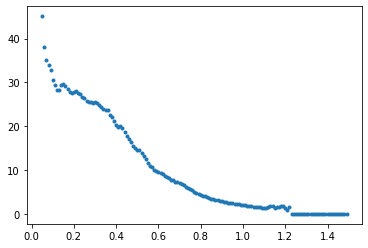

In [6]:
plt.plot(richness_north.z, background_north_1(richness_north.z), ".")

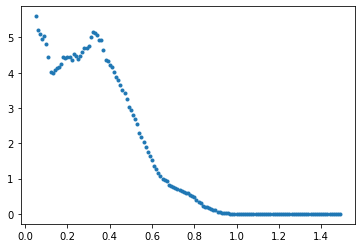

In [7]:
plt.plot(richness_south.z, background_south_2(richness_south.z), ".")

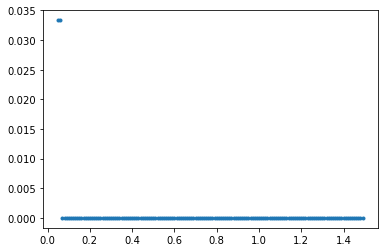

In [8]:
plt.plot(richness_south.z, background_south_3(richness_south.z), ".")

In [9]:
background_south_3(0.9)

array(0.)

In [10]:
north_results["richness_onempc"] = north_results.neighbors - background_north_1(north_results.z_median_central)
north_results["richness_halfmpc"] = north_results.neighbors - background_north_2(north_results.z_median_central)
north_results["richness_tenthmpc"] = north_results.neighbors - background_north_3(north_results.z_median_central)

In [11]:
south_results["richness_onempc"] = south_results.neighbors - background_south_1(south_results.z_median_central)
south_results["richness_halfmpc"] = south_results.neighbors - background_south_2(south_results.z_median_central)
south_results["richness_tenthmpc"] = south_results.neighbors - background_south_3(south_results.z_median_central)

In [12]:
#Corrected mass approx
from scipy.interpolate import interp1d
mass_north = pd.read_csv("north_mass_background_final_third.csv").replace(-np.inf, -50)
mass_south = pd.read_csv("south_mass_background_final_third.csv").replace(-np.inf, -50)
mbackground_north_1 = interp1d(mass_north.z, mass_north["1mpcbkgd"], kind = "linear", fill_value = "extrapolate")
mbackground_south_1 = interp1d(mass_south.z, mass_south["1mpcbkgd"], kind = "linear", fill_value = "extrapolate")
mbackground_north_2 = interp1d(mass_north.z, mass_north["halfmpcbkgd"], kind = "linear", fill_value = "extrapolate")
mbackground_south_2 = interp1d(mass_south.z, mass_south["halfmpcbkgd"], kind = "linear", fill_value = "extrapolate")
mbackground_north_3 = interp1d(mass_north.z, mass_north["tenthmpcbkgd"], kind = "linear", fill_value = "extrapolate")
mbackground_south_3 = interp1d(mass_south.z, mass_south["tenthmpcbkgd"], kind = "linear", fill_value = "extrapolate")

In [13]:
mass_north["tenthmpcbkgd"]

0     -50.0
1     -50.0
2     -50.0
3     -50.0
4     -50.0
       ... 
140   -50.0
141   -50.0
142   -50.0
143   -50.0
144   -50.0
Name: tenthmpcbkgd, Length: 145, dtype: float64

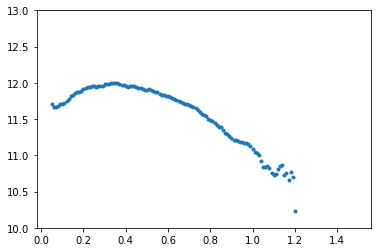

In [14]:
plt.plot(mass_north.z, mbackground_north_1(mass_north.z), ".")
plt.ylim(10, 13);

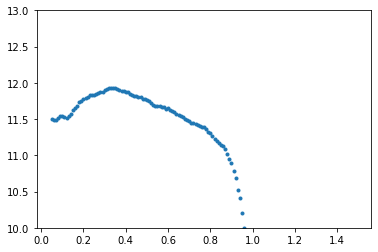

In [15]:
plt.plot(mass_south.z, mbackground_south_1(mass_south.z), ".")
plt.ylim(10, 13);

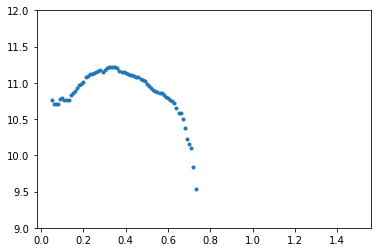

In [16]:
plt.plot(mass_south.z, mbackground_south_2(mass_south.z), ".")
plt.ylim(9, 12);

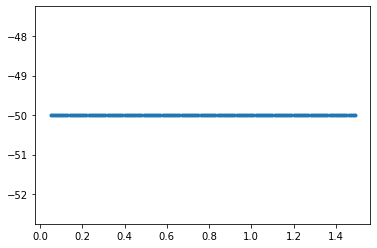

In [17]:
plt.plot(mass_south.z, mbackground_south_3(mass_south.z), ".");

In [18]:
10**(mbackground_south_3(0.9))

1e-50

# Mass Correction Factor

In [19]:
js = [0.19357798810207832, 0.19354767469228779,0.19326573507641892, 0.19346830242386456,0.19350083962912804,0.19344638102658504,0.19343978449358862,0.19358082566255175,0.19361407451886412,0.1933670357081001,0.1934044813173768,0.19355060867090274,0.19353077774866484,0.19349098570001833,0.1934852424401363,0.1935637767302031,0.1934730755413237,0.19343447082430804,0.19344846394383675,0.19345501766889098,0.19346277522205513,0.19342464660204042,0.19341062638552814,0.19344551986539094,0.19344174734768146,0.1934609241256615,0.1933594711641795]

In [20]:
ks = [0.23382159719613094,
 0.233868297595681,
 0.2340892842634665,
 0.2339245938220808,
 0.23390263392865904,
 0.23391177251987721,
 0.233965426041287,
 0.23382411286998922,
 0.233793157563674,
 0.23399746019644582,
 0.23393643947187975,
 0.23385238894845808,
 0.23385066327176013,
 0.233915704411126,
 0.2338864740388902,
 0.23381762471869158,
 0.2339021225924415,
 0.23397353804695076,
 0.23392808621399788,
 0.23395245343207519,
 0.23394473096424648,
 0.23398738210852782,
 0.2339999296080248,
 0.2339645805509769,
 0.23396977123749374,
 0.23393514105629012,
 0.2340055308818063]

In [21]:
ls = [0.006958943588022022,
 0.00694926274857755,
 0.0069211991011780905,
 0.006943961004966217,
 0.0069492552029799945,
 0.006945555941184976,
 0.006939499103247837,
 0.006958499284871327,
 0.006960994299244094,
 0.006932395878395918,
 0.006942815112658893,
 0.00695297329935636,
 0.006955506493342274,
 0.006942977454925035,
 0.00694940794429306,
 0.006959764616499832,
 0.006946104483710809,
 0.00693840200707473,
 0.006942793328995316,
 0.006940275895586232,
 0.0069415055305688134,
 0.006933838337038908,
 0.006932966301193176,
 0.006936897637389609,
 0.006937390821561152,
 0.006939727426896231,
 0.006931541622031537]

In [22]:
j_avg, k_avg, l_avg = (np.mean(js), np.mean(ks), np.mean(ls))
print(j_avg, k_avg, l_avg)

0.1934685649122839 0.23392299620558993 0.0069438686839181476


In [23]:
def mass_coefficient(z):
    return 10**((0.1934685649122839)*z**2 + 0.23392299620558993*z + 0.0069438686839181476)

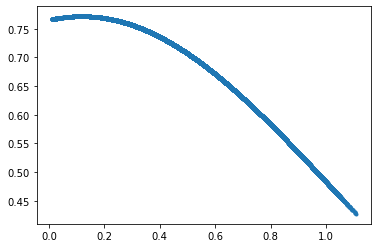

In [24]:
plt.plot(north_results.z_median_central, (mass_coefficient(north_results.z_median_central)/north_results.correction_factor), ".")

In [25]:
north_results["cluster_mass_onempc"] = np.log10(((10**north_results.neighbor_mass)/north_results.correction_factor - 10**mbackground_north_1(north_results.z_median_central))*mass_coefficient(north_results.z_median_central))
north_results["cluster_mass_halfmpc"] = np.log10(((10**north_results.local_neighbor_mass)/north_results.correction_factor - 10**mbackground_north_2(north_results.z_median_central))*mass_coefficient(north_results.z_median_central))
north_results["cluster_mass_tenthmpc"] = np.log10(((10**north_results.ultra_local_neighbor_mass)/north_results.correction_factor - 10**mbackground_north_3(north_results.z_median_central))*mass_coefficient(north_results.z_median_central))

north_results["correction_factor"] = mass_coefficient(north_results.z_median_central)
north_results["mass_bkgd_onempc"] = mbackground_north_1(north_results.z_median_central)
north_results["mass_bkgd_halfmpc"] = mbackground_north_2(north_results.z_median_central)
north_results["mass_bkgd_tenthmpc"] = mbackground_north_3(north_results.z_median_central)

In [26]:
south_results["cluster_mass_onempc"] = np.log10(((10**south_results.neighbor_mass)/south_results.correction_factor - 10**mbackground_south_1(south_results.z_median_central))*mass_coefficient(south_results.z_median_central))
south_results["cluster_mass_halfmpc"] = np.log10(((10**south_results.local_neighbor_mass)/south_results.correction_factor - 10**mbackground_south_2(south_results.z_median_central))*mass_coefficient(south_results.z_median_central))
south_results["cluster_mass_tenthmpc"] = np.log10(((10**south_results.ultra_local_neighbor_mass)/south_results.correction_factor - 10**mbackground_south_3(south_results.z_median_central))*mass_coefficient(south_results.z_median_central))

south_results["correction_factor"] = mass_coefficient(south_results.z_median_central)
south_results["mass_bkgd_onempc"] = mbackground_south_1(south_results.z_median_central)
south_results["mass_bkgd_halfmpc"] = mbackground_south_2(south_results.z_median_central)
south_results["mass_bkgd_tenthmpc"] = mbackground_south_3(south_results.z_median_central)

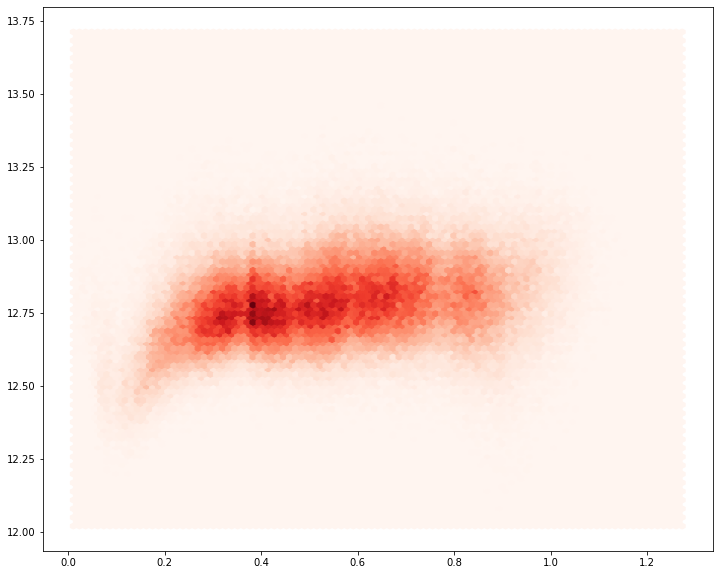

In [27]:
plt.figure(figsize = (12, 10))
plt.hexbin(south_results.z_median_central, south_results.neighbor_mass, cmap = "Reds")
plt.show()

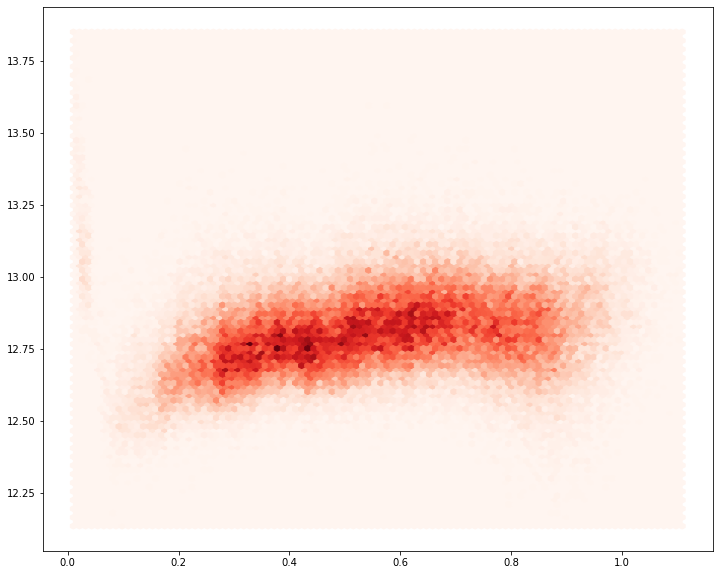

In [28]:
plt.figure(figsize = (12, 10))
plt.hexbin(north_results.z_median_central, north_results.neighbor_mass, cmap = "Reds")
plt.show()

# Removing overlap between north and south

In [29]:
len(north_results)

89932

In [30]:
len(south_results)

233049

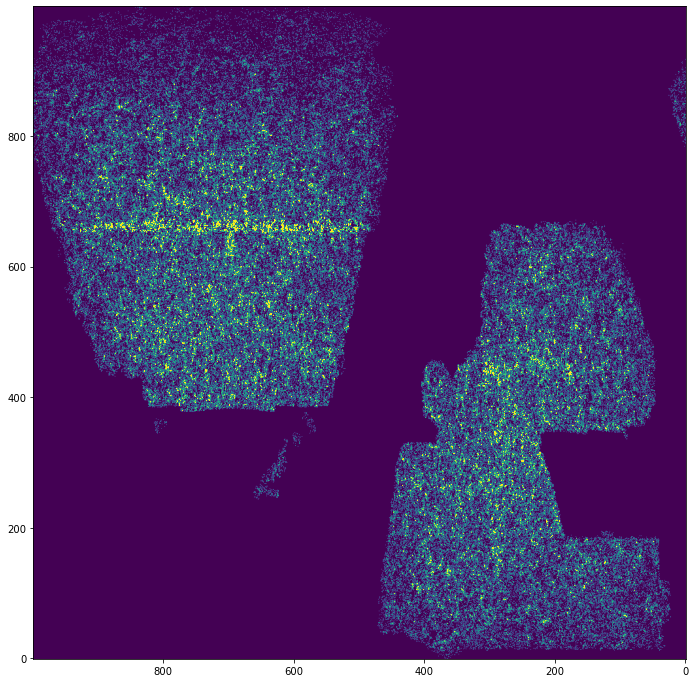

In [31]:
data = pd.concat([north_results, south_results])
H_uneq, xedges, yedges = np.histogram2d(data.DEC_central, (data.RA_central-290)%360, bins = (np.linspace(np.min(data.DEC_central), np.max(data.DEC_central), 1000), np.linspace(np.min((data.RA_central-300)%360), np.max((data.RA_central-300)%360), 1000)))
plt.figure(figsize = (12, 12))
plt.imshow(H_uneq, vmax = 3)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [32]:
check_north = Table.read("/global/cfs/projectdirs/cosmo/data/legacysurvey/dr9/north/survey-bricks-dr9-north.fits.gz")

In [33]:
north_check = pd.DataFrame(np.array((check_north["brickid"], check_north["survey_primary"], check_north["ra"], check_north["dec"])).T, columns = ["BrickID", "survey_primary", "ra", "dec"])

In [34]:
len(north_check)

93548

In [35]:
north_check.survey_primary.sum()

82897.0

In [36]:
check_south = Table.read("/global/cfs/projectdirs/cosmo/data/legacysurvey/dr9/south/survey-bricks-dr9-south.fits.gz")

In [37]:
south_check = pd.DataFrame(np.array((check_south["brickid"], check_south["survey_primary"], check_south["ra"], check_south["dec"])).T, columns = ["BrickID", "survey_primary", "ra", "dec"])

In [38]:
north_results["flag_duplicate"] = 0
south_results["flag_duplicate"] = 0

In [39]:
duplicate = 0
for i in range(len(north_results)):
    if north_check[north_check.BrickID == north_results.iloc[i].BRICKID].survey_primary.values[0] == 0:
        north_results.at[i, "flag_duplicate"] = 1
        duplicate += 1

In [40]:
duplicate

1707

In [41]:
north_results.flag_duplicate.sum()

1707

In [42]:
for i in range(len(south_results)):
    if south_check[south_check.BrickID == south_results.iloc[i].BRICKID].survey_primary.values[0] == 0:
        south_results.at[i, "flag_duplicate"] = 1
        duplicate += 1

In [43]:
duplicate

5579

In [44]:
south_results.flag_duplicate.sum()

3872

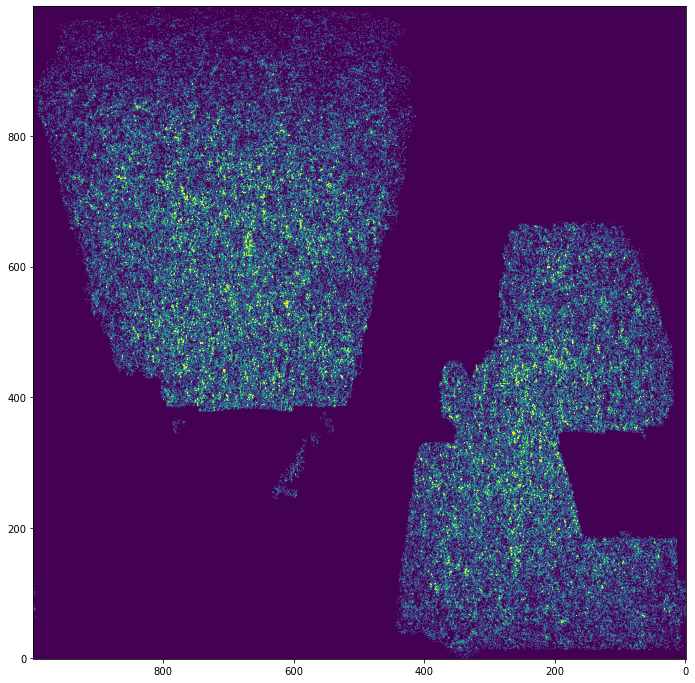

In [45]:
data = pd.concat([north_results, south_results])
data_g = data[data.flag_duplicate == 0]
H_uneq, xedges, yedges = np.histogram2d(data_g.DEC_central, (data_g.RA_central-300)%360, bins = (np.linspace(np.min(data_g.DEC_central), np.max(data_g.DEC_central), 1000), np.linspace(np.min((data_g.RA_central-300)%360), np.max((data_g.RA_central-300)%360), 1000)))
plt.figure(figsize = (12, 12))
plt.imshow(H_uneq, vmax = 3)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

# Foreground flags

In [46]:
all_clusters = pd.concat([north_results, south_results])

In [47]:
sga = Table.read("/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits").to_pandas()

In [48]:
sga2 = sga[np.logical_or(sga.D26>1.5, np.logical_and.reduce((sga.R_MAG_SB24 < 13.5, sga.R_MAG_SB24>0, sga.Z_LEDA <0.05)))]
c = SkyCoord(ra=all_clusters.RA_central.to_numpy()*u.degree, dec=all_clusters.DEC_central.to_numpy()*u.degree)
catalog = SkyCoord(ra=sga2.RA.to_numpy()*u.degree, dec=sga2.DEC.to_numpy()*u.degree)

max_sep = 5.0 * u.arcmin
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
sep_constraint = d2d < max_sep
c_matches = c[sep_constraint]
catalog_matches = catalog[idx[sep_constraint]]

In [49]:
all_clusters[sep_constraint]

,RA_central,DEC_central,z_median_central,z_average_no_wt,z_average_prob,z_average_mass_prob,z_std_central,z_std_no_wt,z_std_prob,z_std_mass_prob,...,richness_onempc,richness_halfmpc,richness_tenthmpc,cluster_mass_onempc,cluster_mass_halfmpc,cluster_mass_tenthmpc,mass_bkgd_onempc,mass_bkgd_halfmpc,mass_bkgd_tenthmpc,flag_duplicate
18,196.309015,31.999687,0.026965,0.227566,0.150084,0.151239,0.009128,0.108381,0.077705,0.077748,...,290.232084,336.557275,351.146434,12.741286,12.463162,11.822916,11.810749,11.055880,-50.0,1
22,196.793878,34.298039,0.030974,0.245273,0.167080,0.167847,0.006880,0.100441,0.083199,0.083158,...,322.151428,366.352090,380.273157,12.887864,12.462399,12.096913,11.792648,11.051071,-50.0,0
29,198.306022,33.984389,0.029462,0.237017,0.135125,0.136746,0.004371,0.113587,0.088443,0.088849,...,350.821494,395.823386,409.996412,12.799827,12.423292,11.672785,11.799475,11.052885,-50.0,0
34,196.780631,34.246894,0.187210,0.288572,0.238065,0.238325,0.005494,0.095605,0.063466,0.062597,...,39.888407,60.829469,67.500000,12.562139,12.379518,12.083345,11.887342,11.217296,-50.0,0
66,190.688452,31.949397,0.403949,0.409112,0.408108,0.408694,0.012935,0.094691,0.062424,0.061531,...,42.313258,57.471970,62.433333,12.651803,12.405633,11.921675,11.950313,11.292364,-50.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232550,330.565920,-9.835569,0.075215,0.165719,0.106260,0.105904,0.009098,0.101401,0.049204,0.048804,...,141.492648,158.310841,163.333333,12.619023,12.324000,11.845642,11.498856,10.713206,-50.0,0
232764,336.600546,-6.335331,0.509065,0.548190,0.515006,0.515823,0.029516,0.103061,0.061874,0.061980,...,20.421006,30.654201,33.466667,12.527162,12.322010,12.132166,11.746017,10.954569,-50.0,0
232914,339.723413,-5.925795,0.313658,0.348071,0.320988,0.320930,0.029663,0.092563,0.065520,0.065307,...,35.808142,51.711793,56.766667,12.368325,12.084325,11.829206,11.923503,11.213307,-50.0,0
233026,339.754996,-5.840849,0.862013,0.766401,0.810587,0.810604,0.060839,0.134922,0.073780,0.072149,...,10.206708,12.240042,12.433333,12.331702,12.084145,11.941104,11.121234,-50.000000,-50.0,0


In [50]:
np.sum(np.logical_and.reduce((all_clusters.MASKBITS == 4096, all_clusters.z_median_central > 0.1, sep_constraint)).astype(int))

230

In [51]:
all_clusters["flag_foreground"] = np.logical_and.reduce((all_clusters.MASKBITS == 4096, all_clusters.z_median_central > 0.1, sep_constraint)).astype(int)

In [52]:
all_clusters[all_clusters.flag_foreground == 1][["RA_central", "DEC_central", "z_median_central"]].tail(60)

,RA_central,DEC_central,z_median_central
154246,38.537475,20.988641,0.131447
156975,346.949903,0.948259,0.365224
160244,18.149235,-40.820204,0.463398
160838,208.687931,21.831485,0.544587
160969,208.688777,21.835143,0.431330
161810,75.988281,-29.599698,0.148480
163942,335.035498,-52.463754,0.101956
165393,177.508220,26.518447,0.109207
166488,233.196933,28.063207,0.141512
167229,35.381012,-58.622702,0.227651


# Footprint flags

In [53]:
cv.getStructuringElement(cv.MORPH_ELLIPSE,(21,21))

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [54]:
test2 = np.zeros((101, 101), dtype = "int")
x,y = np.ogrid[0:101, 0:101]

#get the x and y center points of our image
center_x = test2.shape[0]//2
center_y = test2.shape[1]//2

#create a circle mask which is centered in the middle of the image, and with radius 10 pixels
circle_mask = (x-center_x)**2 + (y-center_y)**2 <= 50**2

test2[circle_mask] = 1
test2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

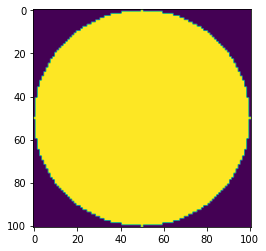

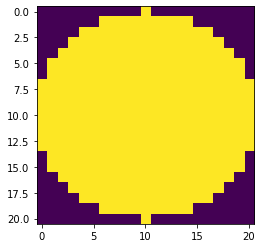

In [55]:
plt.imshow(test2)
plt.show()
plt.imshow(cv.getStructuringElement(cv.MORPH_ELLIPSE,(21,21)))
plt.show()

In [56]:
data = all_clusters.copy()

In [57]:
H_uneq, xedges, yedges = np.histogram2d(data.DEC_central, (data.RA_central-300)%360, bins = (np.linspace(np.min(data.DEC_central), np.max(data.DEC_central), 1000), np.linspace(np.min((data.RA_central-300)%360), np.max((data.RA_central-300)%360), 1000)))

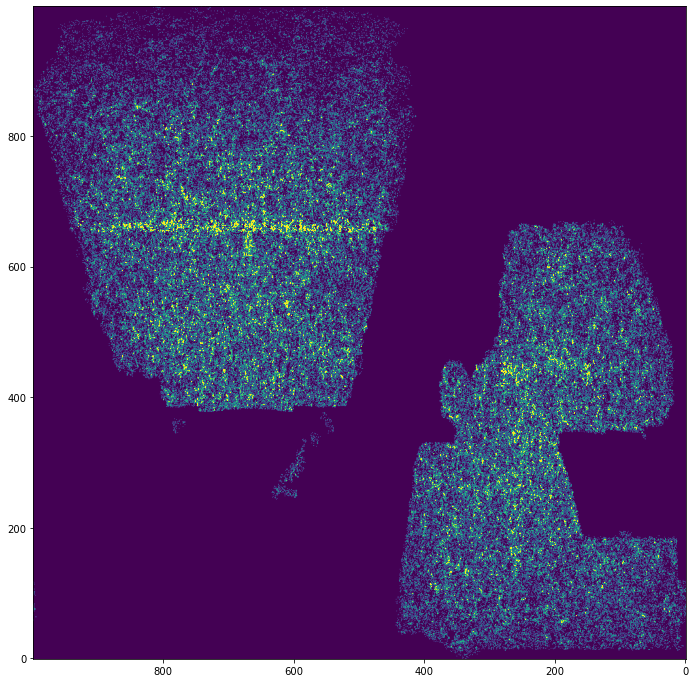

In [58]:
plt.figure(figsize = (12, 12))
plt.imshow(H_uneq, vmax = 3)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [59]:
np.min(data.DEC_central), np.max(data.DEC_central)

(-67.97973664036881, 84.69886222039693)

In [60]:
np.min((data.RA_central-298)%360*np.cos(np.pi/180*data.DEC_central)), np.max((data.RA_central-298)%360*np.cos(np.pi/180*data.DEC_central))

(0.020944224253399348, 320.8826304901982)

In [61]:
H, xedges, yedges = np.histogram2d(data.DEC_central, (data.RA_central-298)%360*np.cos(np.pi/180*data.DEC_central), bins = (np.linspace(-70, 90, 10000), np.linspace(-3, 325, 10000)))

In [62]:
H.shape

(9999, 9999)

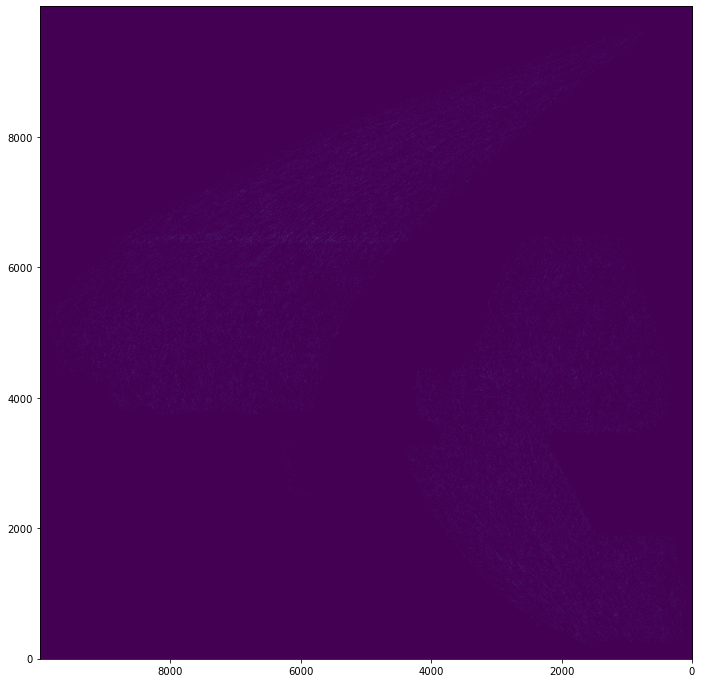

In [63]:
plt.figure(figsize = (12, 12))
plt.imshow(H, vmax = 1)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [64]:
#x_scale = (x_edges.max() - x_edges.min())/(H.shape[1] - 1)
#y_scale = (y_edges.max() - y_edges.min())/(H.shape[0] - 1)
#x_scale = xedges[1]-xedges[0]
#y_scale = yedges[1]-yedges[0]
#x_scale = (np.max(data.DEC_central) - np.min(data.DEC_central))/(H.shape[1] - 1)
#y_scale = (np.max((data.RA_central-300)%360*np.cos(np.pi/180*data.DEC_central)) - np.min((data.RA_central-300)%360*np.cos(np.pi/180*data.DEC_central)))/(H.shape[1] - 1)
x_scale = (90 + 70)/(H.shape[1] - 1)
y_scale = (325+3)/(H.shape[1] - 1)

In [65]:
x_scale, y_scale

(0.016003200640128026, 0.03280656131226245)

In [66]:
dim_x = 0.285/x_scale
dim_y = 0.285/y_scale

In [67]:
dim_x, dim_y

(17.8089375, 8.687286585365854)

In [68]:
(int(np.round(dim_x*2)), np.round(dim_y*2))

(36, 17.0)

In [69]:
test = np.zeros((int(np.round(dim_x*2)+1), int(np.round(dim_y*2)+1)), dtype = "int")
x,y = np.ogrid[0:int(np.round(dim_x*2)+1), 0:int(np.round(dim_y*2)+1)]

#get the x and y center points of our image
center_x = test.shape[0]/2 - 1
center_y = test.shape[1]/2 - 1

#create a circle mask which is centered in the middle of the image, and with radius 10 pixels
circle_mask = (x-center_x)**2/(dim_x**2) + (y-center_y)**2/(dim_y**2) <= 1

test[circle_mask] = 1
kernel = test.copy()

In [70]:
center_x, center_y

(17.5, 8.0)

In [71]:
test

array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

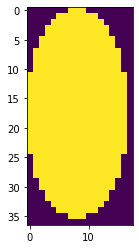

In [72]:
plt.imshow(test)
plt.show()

In [73]:
#ra_min = ((data.RA_central-300)%360*np.cos(np.pi/180*data.DEC_central)).min()
ra_min = -3
data["ra_indices"] = np.round(((data.RA_central-298)%360*np.cos(np.pi/180*data.DEC_central) - ra_min)/y_scale)
#data["dec_indices"] = np.round((data.DEC_central - data.DEC_central.min())/x_scale)
data["dec_indices"] = np.round((data.DEC_central - -70)/x_scale)

In [74]:
data[["ra_indices"]]

,ra_indices
0,6522.0
1,6674.0
2,6573.0
3,6646.0
4,6774.0
...,...
233044,1096.0
233045,1089.0
233046,1318.0
233047,1118.0


In [75]:
(data.RA_central-298)%360*np.cos(np.pi/180*data.DEC_central)

0         210.962226
1         215.965358
2         212.642579
3         215.020548
4         219.236361
             ...    
233044     32.972286
233045     32.717997
233046     40.246938
233047     33.672900
233048     32.574987
Length: 322981, dtype: float64

In [76]:
sampled = data.sample(1000, random_state = 1)
ra_list = sampled.RA_central*np.cos(np.pi/180*sampled.DEC_central)
dec_list = sampled.DEC_central

In [77]:
dec_indices = (dec_list - xedges.min())/x_scale
ra_indices = (ra_list - yedges.min())/y_scale

In [78]:
dec_indices

186252    2421.571332
19238     1785.701616
160294    1748.979624
37168     5129.465464
14105     6621.569161
             ...     
72079     4616.708934
79373     6332.276689
8186      5509.333983
23220     6600.508422
214996    4088.052368
Name: DEC_central, Length: 1000, dtype: float64

In [79]:
dec_list

186252   -31.247108
19238    -41.423059
160294   -42.010728
37168     12.087865
14105     35.966300
            ...    
72079      3.882119
79373     31.336694
8186      18.166977
23220     35.629261
214996    -4.578078
Name: DEC_central, Length: 1000, dtype: float64

In [80]:
xedges[4577:4600]

array([3.23932393, 3.25532553, 3.27132713, 3.28732873, 3.30333033,
       3.31933193, 3.33533353, 3.35133513, 3.36733673, 3.38333833,
       3.39933993, 3.41534153, 3.43134313, 3.44734473, 3.46334633,
       3.47934793, 3.49534953, 3.51135114, 3.52735274, 3.54335434,
       3.55935594, 3.57535754, 3.59135914])

In [81]:
ra_indices

186252      442.989326
19238      1725.079919
160294      500.920212
37168      4824.609870
14105      4769.659436
              ...     
72079     10894.534639
79373      4228.347239
8186       7638.391872
23220      3647.076028
214996     1304.284385
Length: 1000, dtype: float64

In [82]:
ra_list

186252     11.532956
19238      53.593940
160294     13.433470
37168     155.278860
14105     153.476125
             ...    
72079     354.412219
79373     135.717533
8186      247.589371
23220     116.648023
214996     39.789086
Length: 1000, dtype: float64

In [83]:
yedges[1393:1450]

array([42.6949695 , 42.72777278, 42.76057606, 42.79337934, 42.82618262,
       42.8589859 , 42.89178918, 42.92459246, 42.95739574, 42.99019902,
       43.0230023 , 43.05580558, 43.08860886, 43.12141214, 43.15421542,
       43.1870187 , 43.21982198, 43.25262526, 43.28542854, 43.31823182,
       43.3510351 , 43.38383838, 43.41664166, 43.44944494, 43.48224822,
       43.51505151, 43.54785479, 43.58065807, 43.61346135, 43.64626463,
       43.67906791, 43.71187119, 43.74467447, 43.77747775, 43.81028103,
       43.84308431, 43.87588759, 43.90869087, 43.94149415, 43.97429743,
       44.00710071, 44.03990399, 44.07270727, 44.10551055, 44.13831383,
       44.17111711, 44.20392039, 44.23672367, 44.26952695, 44.30233023,
       44.33513351, 44.36793679, 44.40074007, 44.43354335, 44.46634663,
       44.49914991, 44.5319532 ])

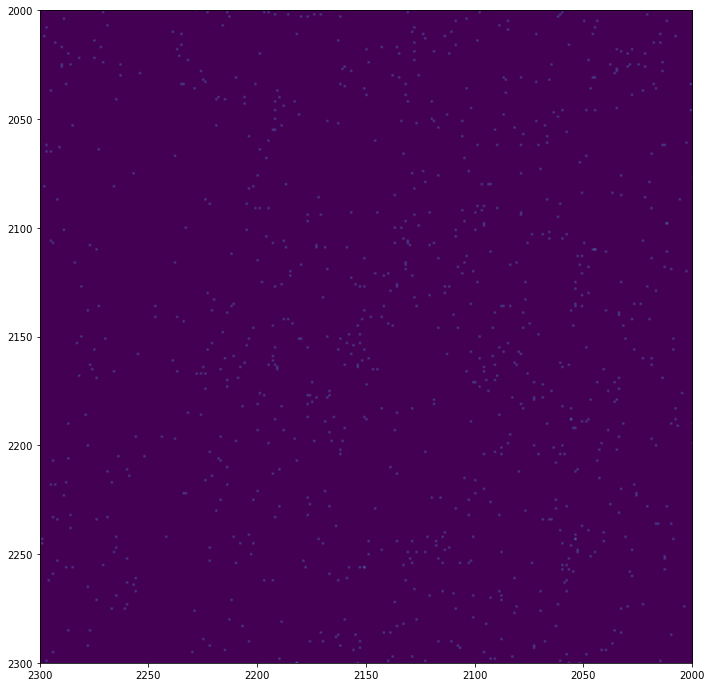

In [84]:
plt.figure(figsize = (12, 12))
plt.imshow(H)
plt.xlim(2000, 2300)
plt.ylim(2000, 2300)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [85]:
H0 = np.clip(H, 0, 1)

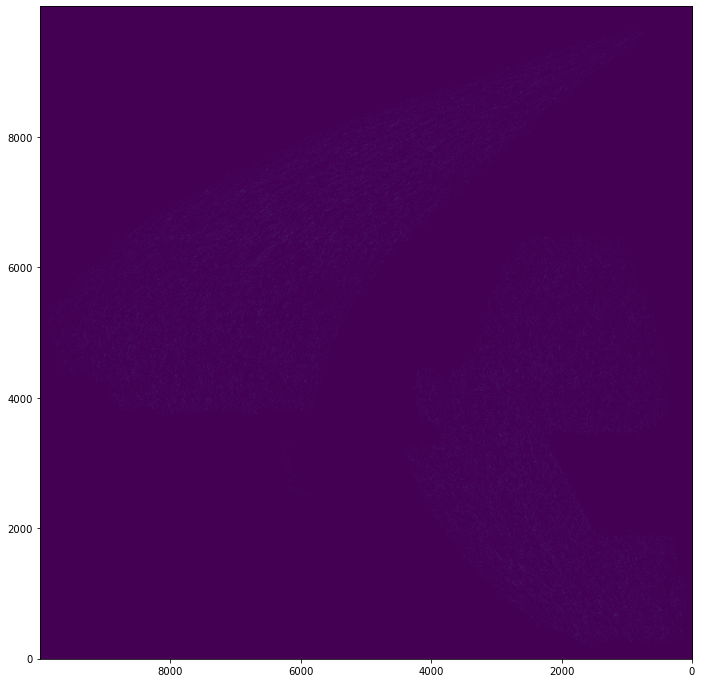

In [86]:
plt.figure(figsize = (12, 12))
plt.imshow(H0)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [87]:
kernel = test2.astype("uint8")
closing = cv.morphologyEx(H0, cv.MORPH_CLOSE, kernel)

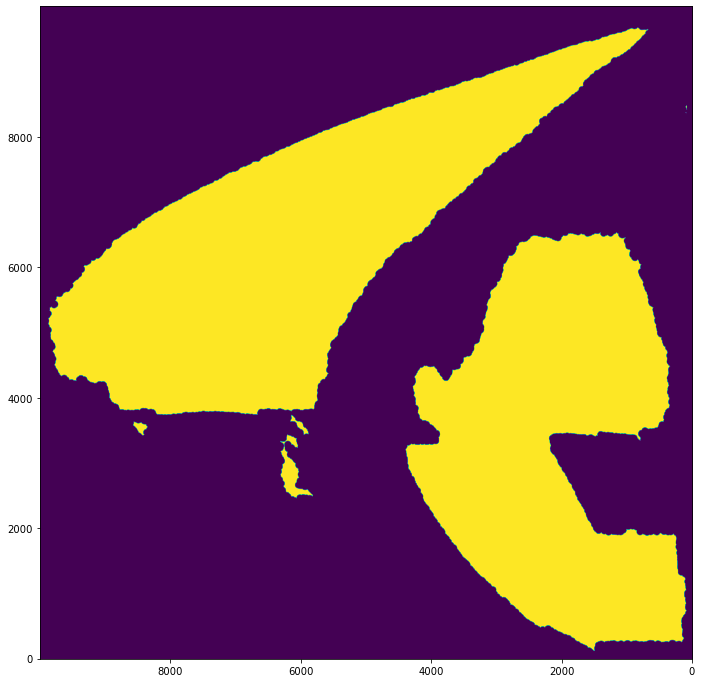

In [88]:
plt.figure(figsize = (12, 12))
plt.imshow(closing)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [89]:
kernel2 = test.astype("uint8")
eroded = cv.erode(closing, kernel2)

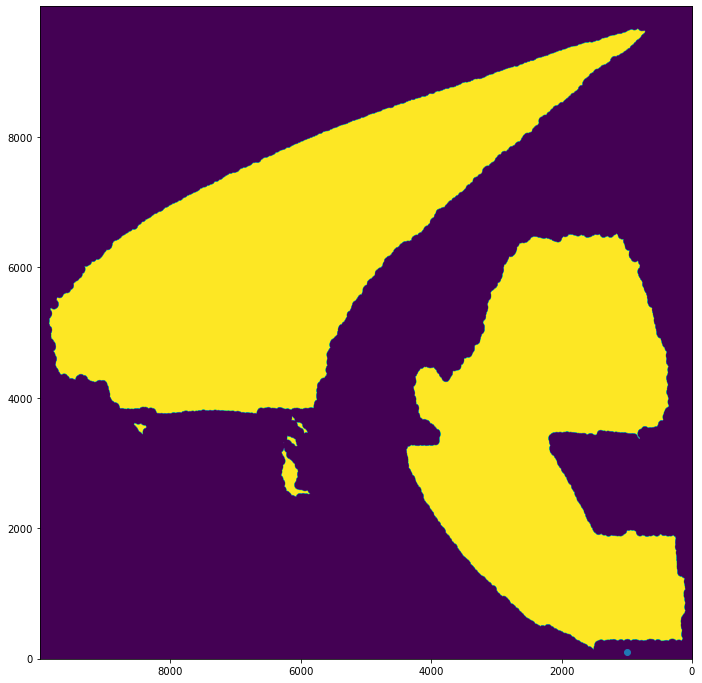

In [90]:
plt.figure(figsize = (12, 12))
plt.imshow(eroded)
plt.plot(1000, 100, 'o')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [91]:
np.save("clumpr_mask", eroded)

In [92]:
eroded[[235, 345, 0, 1000], [456, 345, 0, 100]]

array([0., 1., 0., 0.])

In [93]:
eroded[0, 0]

0.0

In [94]:
data["edge_mask"] = eroded[data.dec_indices.astype("int").to_list(), data.ra_indices.astype("int").to_list()]

In [95]:
data2 = data[data.edge_mask == 0]
len(data2)

5063

In [96]:
H_uneq2, xedges, yedges = np.histogram2d(data2.DEC_central, (data2.RA_central-298)%360, bins = (np.linspace(np.min(data2.DEC_central), np.max(data2.DEC_central), 1000), np.linspace(np.min((data2.RA_central-298)%360), np.max((data2.RA_central-298)%360), 1000)))

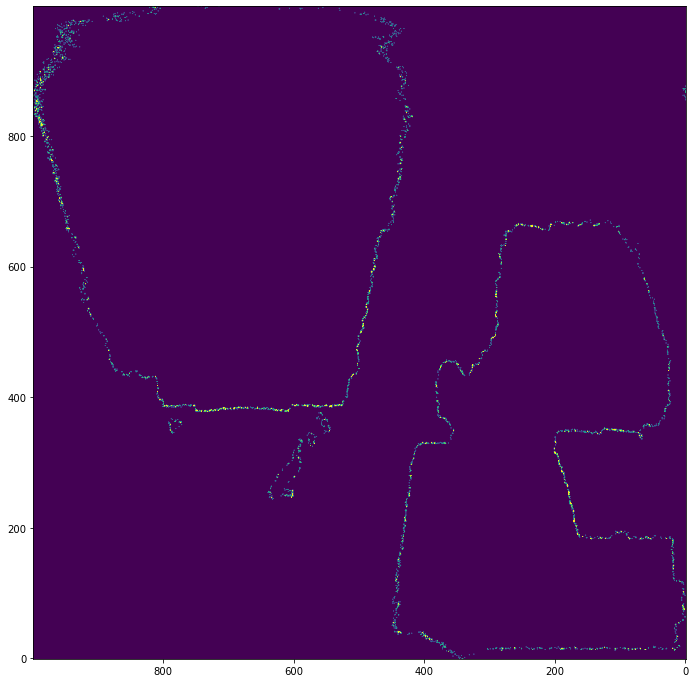

In [97]:
plt.figure(figsize = (12, 12))
plt.imshow(H_uneq2, vmax = 1)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

# Removing weird footprint areas

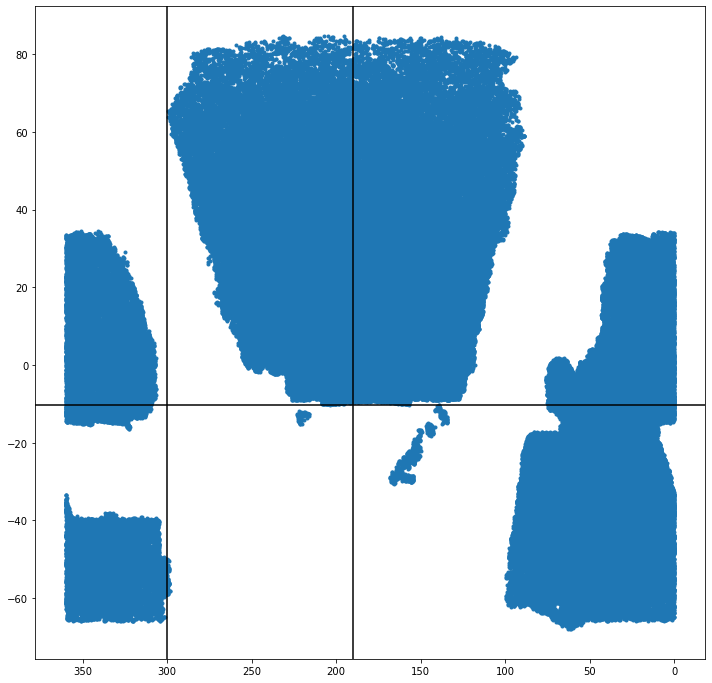

In [98]:
plt.figure(figsize = (12, 12))
plt.plot(data.RA_central, data.DEC_central, ".")
plt.axhline(-10.3, color = "k")
plt.axvline(300, color = "k")
plt.axvline(190, color = "k")
plt.gca().invert_xaxis()

In [99]:
data_restricted = data[~np.logical_and.reduce((data.RA_central > 110, data.RA_central < 250, data.DEC_central < -10.3))]

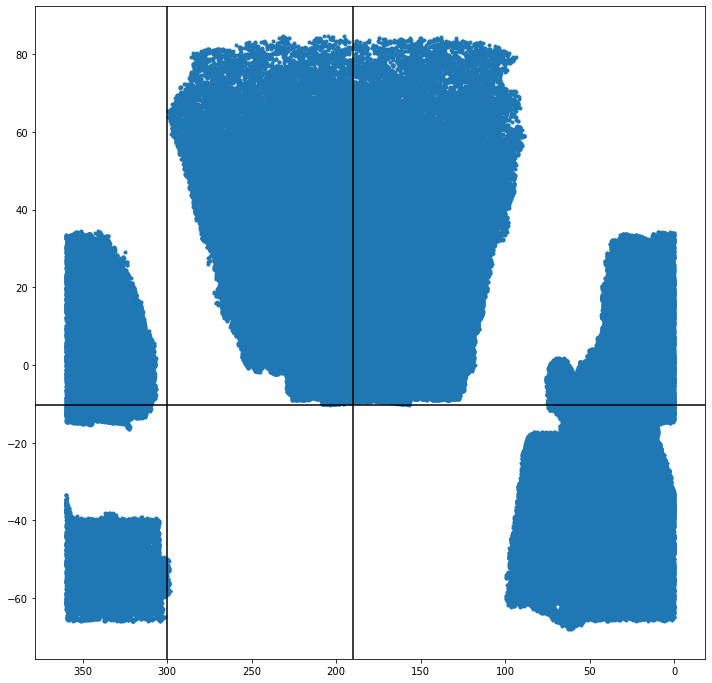

In [100]:
plt.figure(figsize = (12, 12))
plt.plot(data_restricted.RA_central, data_restricted.DEC_central, ".")
plt.axhline(-10.3, color = "k")
plt.axvline(300, color = "k")
plt.axvline(190, color = "k")
plt.gca().invert_xaxis()

In [101]:
data["footprint_flag"] = np.logical_and.reduce((data.RA_central > 110, data.RA_central < 250, data.DEC_central < -10.3)).astype(int)

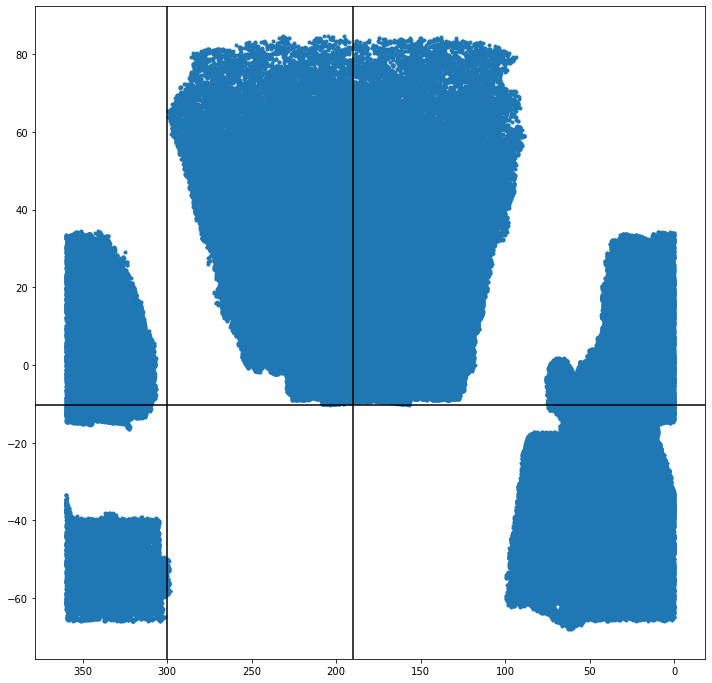

In [102]:
plt.figure(figsize = (12, 12))
plt.plot(data[data.footprint_flag == 0].RA_central, data[data.footprint_flag == 0].DEC_central, ".")
plt.axhline(-10.3, color = "k")
plt.axvline(300, color = "k")
plt.axvline(190, color = "k")
plt.gca().invert_xaxis()

In [103]:
data.columns

Index(['RA_central', 'DEC_central', 'z_median_central', 'z_average_no_wt',
       'z_average_prob', 'z_average_mass_prob', 'z_std_central', 'z_std_no_wt',
       'z_std_prob', 'z_std_mass_prob', 'z_stde_no_wt', 'z_stde_prob',
       'z_stde_mass_prob', 'RELEASE', 'BRICKID', 'OBJID', 'MASKBITS', 'gid',
       'mass_central', 'neighbor_mass', 'local_neighbor_mass',
       'ultra_local_neighbor_mass', 'correction_factor', 'neighbors',
       'local_neighbors', 'ultra_local_neighbors', 'richness_onempc',
       'richness_halfmpc', 'richness_tenthmpc', 'cluster_mass_onempc',
       'cluster_mass_halfmpc', 'cluster_mass_tenthmpc', 'mass_bkgd_onempc',
       'mass_bkgd_halfmpc', 'mass_bkgd_tenthmpc', 'flag_duplicate',
       'flag_foreground', 'ra_indices', 'dec_indices', 'edge_mask',
       'footprint_flag'],
      dtype='object')

In [104]:
len(data)

322981

In [105]:
saving = data.copy().to_records(index = False)

In [106]:
fits.writeto("all_clusters_final_2023_raw.fits", saving)

# Final clean

In [107]:
data_cleaner = data[~np.logical_or.reduce((data.z_median_central < 0.1, data.flag_duplicate == 1))]

In [108]:
data_cleaner_d = data_cleaner.drop(columns = ["flag_duplicate", "ra_indices", "dec_indices", 'z_std_no_wt', 'z_std_prob', 'z_std_mass_prob']).copy()

In [109]:
data_cleaner_d

,RA_central,DEC_central,z_median_central,z_average_no_wt,z_average_prob,z_average_mass_prob,z_std_central,z_stde_no_wt,z_stde_prob,z_stde_mass_prob,...,richness_tenthmpc,cluster_mass_onempc,cluster_mass_halfmpc,cluster_mass_tenthmpc,mass_bkgd_onempc,mass_bkgd_halfmpc,mass_bkgd_tenthmpc,flag_foreground,edge_mask,footprint_flag
0,193.849401,34.456471,0.620361,0.612266,0.616049,0.616323,0.024668,0.010973,0.007319,0.007251,...,60.033333,13.079155,12.902120,12.334141,11.792897,10.989391,-50.0,0,1.0,0
1,199.613594,34.359489,0.412146,0.378484,0.380455,0.380630,0.010519,0.007628,0.006238,0.006224,...,94.233333,12.848106,12.567858,12.207282,11.949927,11.290573,-50.0,0,1.0,0
2,197.302646,34.909643,0.320092,0.344044,0.333670,0.334049,0.012730,0.007319,0.006134,0.006096,...,88.066667,12.817518,12.696227,12.344371,11.986071,11.307027,-50.0,0,1.0,0
3,196.113499,33.587028,0.187818,0.244615,0.213247,0.213212,0.004308,0.006309,0.003518,0.003497,...,143.700000,12.844305,12.641299,12.212231,11.888138,11.218105,-50.0,0,1.0,0
4,197.896391,32.482776,0.611117,0.631119,0.646819,0.647613,0.024086,0.017511,0.011208,0.011049,...,33.466667,12.912443,12.775336,12.387573,11.803400,11.025291,-50.0,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233044,331.341322,-8.532612,0.997785,0.889175,0.928041,0.927431,0.076825,0.029736,0.027542,0.027673,...,7.633333,12.357384,12.226926,12.034512,-50.000000,-50.000000,-50.0,0,1.0,0
233045,331.121150,-8.948731,0.898265,0.831198,0.861282,0.860919,0.066619,0.025712,0.016084,0.016008,...,11.033333,12.238025,12.022379,12.022379,10.898559,-50.000000,-50.0,0,1.0,0
233046,338.590253,-7.457263,0.998693,0.896095,0.902503,0.901866,0.299123,0.017843,0.017565,0.017657,...,8.600000,12.576819,12.108529,11.930295,-50.000000,-50.000000,-50.0,0,1.0,0
233047,332.054153,-8.581547,0.973275,0.874699,0.910173,0.910049,0.078490,0.028145,0.025350,0.025281,...,8.066667,12.263769,12.158200,11.955529,-9.712922,-50.000000,-50.0,0,1.0,0


In [110]:
new_column_order_long = ['RA_central', 'DEC_central', 'z_median_central', 'z_average_no_wt',\
       'z_average_prob', 'z_average_mass_prob', 'z_std_central', 'z_stde_no_wt',\
       'z_stde_prob', 'z_stde_mass_prob', 'RELEASE', 'BRICKID', 'OBJID',\
       'MASKBITS', 'gid', 'mass_central',\
       'cluster_mass_onempc', 'cluster_mass_halfmpc', 'cluster_mass_tenthmpc',\
       'mass_bkgd_onempc', 'mass_bkgd_halfmpc', 'mass_bkgd_tenthmpc', 'correction_factor',\
       'neighbors', 'local_neighbors', 'ultra_local_neighbors',\
       'richness_onempc', 'richness_halfmpc', 'richness_tenthmpc', \
       'flag_foreground','edge_mask', 'footprint_flag']

In [111]:
new_column_names_long = ['RA_central', 'DEC_central', 'z_median_central', 'z_average_no_wt',\
       'z_average_prob', 'z_average_mass_prob', 'z_std_central', 'z_stde_no_wt',\
       'z_stde_prob', 'z_stde_mass_prob', 'RELEASE', 'BRICKID', 'OBJID',\
       'MASKBITS', 'gid', 'mass_central',\
       'cluster_mass_onempc', 'cluster_mass_halfmpc', 'cluster_mass_tenthmpc',\
       'mass_bkgd_onempc', 'mass_bkgd_halfmpc', 'mass_bkgd_tenthmpc', 'correction_factor',\
       'neighbors_onempc', 'neighbors_halfmpc', 'neighbors_tenthmpc',\
       'richness_onempc', 'richness_halfmpc', 'richness_tenthmpc', \
       'flag_foreground','edge_mask', 'footprint_flag']

In [112]:
data_cleaner_r = data_cleaner_d[new_column_order_long]

In [113]:
data_cleaner_r.columns = new_column_names_long

In [114]:
data_cleaner_r.columns

Index(['RA_central', 'DEC_central', 'z_median_central', 'z_average_no_wt',
       'z_average_prob', 'z_average_mass_prob', 'z_std_central',
       'z_stde_no_wt', 'z_stde_prob', 'z_stde_mass_prob', 'RELEASE', 'BRICKID',
       'OBJID', 'MASKBITS', 'gid', 'mass_central', 'cluster_mass_onempc',
       'cluster_mass_halfmpc', 'cluster_mass_tenthmpc', 'mass_bkgd_onempc',
       'mass_bkgd_halfmpc', 'mass_bkgd_tenthmpc', 'correction_factor',
       'neighbors_onempc', 'neighbors_halfmpc', 'neighbors_tenthmpc',
       'richness_onempc', 'richness_halfmpc', 'richness_tenthmpc',
       'flag_foreground', 'edge_mask', 'footprint_flag'],
      dtype='object')

In [115]:
data_cleaner_r

,RA_central,DEC_central,z_median_central,z_average_no_wt,z_average_prob,z_average_mass_prob,z_std_central,z_stde_no_wt,z_stde_prob,z_stde_mass_prob,...,correction_factor,neighbors_onempc,neighbors_halfmpc,neighbors_tenthmpc,richness_onempc,richness_halfmpc,richness_tenthmpc,flag_foreground,edge_mask,footprint_flag
0,193.849401,34.456471,0.620361,0.612266,0.616049,0.616323,0.024668,0.010973,0.007319,0.007251,...,1.684676,60.033333,30.900000,6.200000,50.947763,58.034536,60.033333,0,1.0,0
1,199.613594,34.359489,0.412146,0.378484,0.380455,0.380630,0.010519,0.007628,0.006238,0.006224,...,1.368414,94.233333,33.233333,3.700000,74.452290,89.422604,94.233333,0,1.0,0
2,197.302646,34.909643,0.320092,0.344044,0.333670,0.334049,0.012730,0.007319,0.006134,0.006096,...,1.263699,88.066667,37.466667,2.000000,63.320826,82.068207,88.066667,0,1.0,0
3,196.113499,33.587028,0.187818,0.244615,0.213247,0.213212,0.004308,0.006309,0.003518,0.003497,...,1.142098,143.700000,67.866667,8.300000,116.112704,137.037568,143.700000,0,1.0,0
4,197.896391,32.482776,0.611117,0.631119,0.646819,0.647613,0.024086,0.017511,0.011208,0.011049,...,1.667831,33.466667,16.533333,3.733333,24.144604,31.289016,33.466667,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233044,331.341322,-8.532612,0.997785,0.889175,0.928041,0.927431,0.076825,0.029736,0.027542,0.027673,...,2.709951,7.633333,3.366667,1.000000,6.411187,7.633333,7.633333,0,1.0,0
233045,331.121150,-8.948731,0.898265,0.831198,0.861282,0.860919,0.066619,0.025712,0.016084,0.016008,...,2.361428,11.033333,4.200000,0.966667,9.074658,10.933333,11.033333,0,1.0,0
233046,338.590253,-7.457263,0.998693,0.896095,0.902503,0.901866,0.299123,0.017843,0.017565,0.017657,...,2.713467,8.600000,3.533333,0.400000,7.386933,8.600000,8.600000,0,1.0,0
233047,332.054153,-8.581547,0.973275,0.874699,0.910173,0.910049,0.078490,0.028145,0.025350,0.025281,...,2.617467,8.066667,3.533333,0.966667,6.688501,8.066667,8.066667,0,1.0,0


In [116]:
saving = data_cleaner_r.copy().to_records(index = False)

In [117]:
fits.writeto("DESI_clusters_final_2023_full.fits", saving)

In [118]:
data_clean = data_cleaner_r[~np.logical_or.reduce((data_cleaner_r.edge_mask == 0, data_cleaner_r.footprint_flag == 1, data_cleaner_r.flag_foreground == 1))]

In [119]:
data_clean

,RA_central,DEC_central,z_median_central,z_average_no_wt,z_average_prob,z_average_mass_prob,z_std_central,z_stde_no_wt,z_stde_prob,z_stde_mass_prob,...,correction_factor,neighbors_onempc,neighbors_halfmpc,neighbors_tenthmpc,richness_onempc,richness_halfmpc,richness_tenthmpc,flag_foreground,edge_mask,footprint_flag
0,193.849401,34.456471,0.620361,0.612266,0.616049,0.616323,0.024668,0.010973,0.007319,0.007251,...,1.684676,60.033333,30.900000,6.200000,50.947763,58.034536,60.033333,0,1.0,0
1,199.613594,34.359489,0.412146,0.378484,0.380455,0.380630,0.010519,0.007628,0.006238,0.006224,...,1.368414,94.233333,33.233333,3.700000,74.452290,89.422604,94.233333,0,1.0,0
2,197.302646,34.909643,0.320092,0.344044,0.333670,0.334049,0.012730,0.007319,0.006134,0.006096,...,1.263699,88.066667,37.466667,2.000000,63.320826,82.068207,88.066667,0,1.0,0
3,196.113499,33.587028,0.187818,0.244615,0.213247,0.213212,0.004308,0.006309,0.003518,0.003497,...,1.142098,143.700000,67.866667,8.300000,116.112704,137.037568,143.700000,0,1.0,0
4,197.896391,32.482776,0.611117,0.631119,0.646819,0.647613,0.024086,0.017511,0.011208,0.011049,...,1.667831,33.466667,16.533333,3.733333,24.144604,31.289016,33.466667,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233044,331.341322,-8.532612,0.997785,0.889175,0.928041,0.927431,0.076825,0.029736,0.027542,0.027673,...,2.709951,7.633333,3.366667,1.000000,6.411187,7.633333,7.633333,0,1.0,0
233045,331.121150,-8.948731,0.898265,0.831198,0.861282,0.860919,0.066619,0.025712,0.016084,0.016008,...,2.361428,11.033333,4.200000,0.966667,9.074658,10.933333,11.033333,0,1.0,0
233046,338.590253,-7.457263,0.998693,0.896095,0.902503,0.901866,0.299123,0.017843,0.017565,0.017657,...,2.713467,8.600000,3.533333,0.400000,7.386933,8.600000,8.600000,0,1.0,0
233047,332.054153,-8.581547,0.973275,0.874699,0.910173,0.910049,0.078490,0.028145,0.025350,0.025281,...,2.617467,8.066667,3.533333,0.966667,6.688501,8.066667,8.066667,0,1.0,0


In [120]:
data_clean_d = data_clean.drop(columns = ['mass_bkgd_onempc', 'mass_bkgd_halfmpc', 'mass_bkgd_tenthmpc', 'correction_factor', 'neighbors_onempc', 'neighbors_halfmpc', 'neighbors_tenthmpc', "edge_mask", "flag_foreground", "footprint_flag"]).copy()

In [121]:
data_clean_d.columns

Index(['RA_central', 'DEC_central', 'z_median_central', 'z_average_no_wt',
       'z_average_prob', 'z_average_mass_prob', 'z_std_central',
       'z_stde_no_wt', 'z_stde_prob', 'z_stde_mass_prob', 'RELEASE', 'BRICKID',
       'OBJID', 'MASKBITS', 'gid', 'mass_central', 'cluster_mass_onempc',
       'cluster_mass_halfmpc', 'cluster_mass_tenthmpc', 'richness_onempc',
       'richness_halfmpc', 'richness_tenthmpc'],
      dtype='object')

In [122]:
saving = data_clean_d.copy().to_records(index = False)

In [123]:
fits.writeto("DESI_clusters_final_2023.fits", saving)